# Feature Engineering

## 特征工程的目标

特征工程的目标很简单：就是为了使您的数据更适合机器学习模型的特征。这可能意味着让您的数据更易于预测，也可能意味着使您的数据更易于理解。


你可能会进行特征工程来：

- 改进模型的预测性能
- 减少计算或数据需求
- 提高结果的可解释性



## 特征工程的方法
- 特征转换：将特征转换为更适合模型的形式。
    - 将分类特征转换为数字特征，比如one-hot编码
    - 将数字特征转换为分类特征，比如分箱 binning。 
        - `pd.cut()`用于自定义的或者等宽的区间分箱优先保证区间大小相同
        - `pd.qcut()`用于分位数分箱优先保证每个箱子的数据量相同
- 特征生成：从现有特征中生成新特征，使模型更容易学习
- 特征选择：选择最有用的特征，以便减少数据和模型的开销





In [3]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. BaseLine Model
BaseLine Model是指在没有进行任何特征工程的情况下，直接使用原始数据进行建模，得到的模型称为BaseLine Model。
一般来说，我们的目标是在BaseLine Model的基础上，通过特征工程，使得模型的效果有所提升。

Baseline Model一般使用最简单的模型，比如线性回归、逻辑回归、决策树等等。当模型完成后，使用一个评价指标来评价模型的效果，比如回归问题中常用的MSE、MAE、R2等，分类问题中常用的AUC、KS、F1等。

在得到Baseline Model的效果后，我们就可以进行特征工程，将特征进行组合、转换、筛选等等，然后再次训练模型，得到新的模型效果。如果新的模型效果比Baseline Model的效果要好，那么说明我们的特征工程是有效的。

在进行特征工程和模型优化时，是否应该保持与基线模型相同的算法，这取决于你的目标和实验设计。通常，有两种主要的方法：

1. **保持相同算法，改变特征选择**：这种方法的优点在于它可以让你直接评估特征工程的效果。如果你在特征工程之后仍然使用随机森林算法，那么任何性能上的提升或下降都可以直接归因于新特征的影响。这样做有助于理解哪些特征是有用的，哪些可能不是。

2. **改变算法和特征选择**：另一种方法是在特征工程之后尝试不同的算法。这种方法可以帮助你找到最适合新特征集的模型。有时，新的特征可能更适合不同类型的算法。例如，一些特征可能对某些模型（如基于树的模型）更有效，而对其他模型（如线性模型）效果不佳。

在实际操作中，你可以先采用第一种方法，只改变特征选择，以评估这些新特征对模型性能的影响。一旦确定了有效的特征集，再尝试不同的算法，以找到最佳的模型配置。这种迭代方法可以帮助你更全面地理解数据，并找到最优的模型。


# 2. Mutual Information (MI)
当处理一个新数据集，可能有很多特征，此时我们需要构建一个`feature utility metric`，来帮助我们选择最有用的特征。这个metric可以用来衡量每个特征与目标变量之间的相关性. 

同时，使用MI得分可以为我们找到最有用的特征提供指导。

***
---
## 2.1 Definition of Mutual Information
相互信息（Mutual Information, MI）是一种衡量两个变量之间共享信息量的度量。它告诉我们一个变量包含关于另一个变量的多少信息。在数据科学和信息论中，这是一个非常重要的概念，用于理解变量之间的关系和依赖性。

与相关性不同，相互信息可以捕获任何类型的依赖性，包括线性和非线性关系。它是一个非负值，如果两个变量独立，则相互信息为零。相互信息的值越大，表示两个变量之间的依赖性越强。

相互信息定义为两个变量的联合分布和各自独立分布的相对熵（或称KL散度）。用公式表示：

MI(X; Y) = ∑_{x ∈ X} ∑_{y ∈ Y} p(x, y) log( p(x, y) / (p(x) p(y)) )

其中，\( p(x, y) \) 是X和Y的联合概率分布，\( p(x) \) 和 \( p(y) \) 是X和Y的边缘概率分布。

相互信息的几个关键特点包括：
1. **非负性**：相互信息的值总是非负的，即 \( MI(X;Y) \geq 0 \)。
2. **对称性**：相互信息是对称的，即 \( MI(X;Y) = MI(Y;X) \)。
3. **信息量衡量**：如果X和Y独立，则 \( MI(X;Y) = 0 \)。这意味着一个变量对另一个变量没有提供任何信息。
4. **应用**：在数据科学中，相互信息可以用于特征选择、建模变量间的依赖关系、信息论分析等。









## 2.2 Mutual Information for Feature Selection

1. **单变量预测潜力**：
   - 相互信息可以帮助你理解一个特征作为单独预测目标变量的相对潜力。
   - 这意味着，如果一个特征与目标变量之间的相互信息值较高，它可能是一个好的预测因子。

2. **特征间交互的局限性**：
   - 有些特征可能在与其他特征交互时非常有信息量，但如果单独考虑可能就不那么有用。
   - 相互信息无法检测特征之间的交互作用。它是一种单变量度量方法，只能评估单个特征与目标变量之间的信息共享程度。
   - 这意味着即使一个特征单独看来与目标变量的相互信息低，它可能在与其他特征结合时变得重要。

3. **特征的实际用途与模型的关系**：
   - 特征的实际有效性取决于你用它的模型。一个特征只有在其与目标变量的关系是模型能够学习到的情况下才有用。
   - 即使一个特征的相互信息得分很高，并不意味着你的模型就一定能有效地利用这些信息。
   - 在某些情况下，可能需要先对特征进行转换（如规范化、分箱、编码等），以使其与目标的关联更明显，从而更好地被模型利用。

- `mutual_info_classif`：用于分类问题, 评估离散目标变量
- `mutual_info_regression`：用于回归问题, 评估连续目标变量

得到MI Scores后，可以绘制成barplot，以便于观察特征的重要性。

In [39]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# 生成一些模拟数据
np.random.seed(0)

# 离散特征
X_classif = pd.DataFrame({'feature1': np.random.randint(0, 4, 100),
                          'feature2': np.random.randint(0, 3, 100),
                          'feature3': np.random.rand(100)})
y_classif = np.random.randint(0, 2, 100)  # 二分类目标变量

# 连续特征
X_regress = pd.DataFrame({'feature1': np.random.rand(100),
                          'feature2': np.random.rand(100),
                          'feature3': np.random.randint(0, 5, 100)})
y_regress = np.random.rand(100) * 100  # 连续目标变量

# 使用 mutual_info_classif
mi_scores_classif = mutual_info_classif(X_classif, y_classif)
mi_scores_classif = pd.Series(mi_scores_classif, index=X_classif.columns, name="MI Scores (Classif)")
mi_scores_classif = mi_scores_classif.sort_values(ascending=False)

# 使用 mutual_info_regression
mi_scores_regress = mutual_info_regression(X_regress, y_regress)
mi_scores_regress = pd.Series(mi_scores_regress, index=X_regress.columns, name="MI Scores (Regress)")
mi_scores_regress = mi_scores_regress.sort_values(ascending=False)

print(mi_scores_classif)
print(mi_scores_regress)



feature2    0.005029
feature1    0.000000
feature3    0.000000
Name: MI Scores (Classif), dtype: float64
feature1    0.173375
feature2    0.015219
feature3    0.000000
Name: MI Scores (Regress), dtype: float64


将生成MI并转换成降序Series的函数以及绘制barplot的函数分别封装起来，方便后续使用。

In [40]:
# 生成MI并转换成降序Series
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 绘制barplot
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores) # plt.barh()绘制水平条形图
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## 2.3 Discrete and Continuous Features

1. **离散特征与连续特征的不同处理**：
   - 在scikit-learn中，用于计算相互信息的算法会根据特征是离散的还是连续的来采用不同的处理方式。
   - 离散特征和连续特征在信息量的计算和统计性质上有所不同，因此需要不同的方法来处理。

2. **如何识别离散和连续特征**：
   - 作为一个经验法则，任何具有浮点数（`float`）数据类型的特征都被视为非离散（即连续特征）。
   - 而分类特征，通常是对象（`object`）或分类（`categorical`）数据类型，可以通过给它们进行`编码`来作为离散特征处理。

3. **标签编码 Label encoding**：
   - 标签编码是一种将分类数据转换为数值形式的方法，这使得算法能够更有效地处理这些数据。
   - 在标签编码中，每个类别都被赋予一个唯一的整数值。例如，如果有一个分类特征有三个类别“红色”、“蓝色”和“绿色”，它们可能分别被编码为0、1和2。

4. **独热编码 One-Hot encoding**：
   - 独热编码是一种将分类数据转换为数值形式的方法，这使得算法能够更有效地处理这些数据。
   - 在独热编码中，为每一个类别创建一个新的二进制列，用0和1表示该类别是否出现。
   - 例如，如果有一个分类特征有三个类别“红色”、“蓝色”和“绿色”，它们可能分别被编码为[1,0,0]、[0,1,0]和[0,0,1]。

In [38]:
# LabelEncoder用于标签编码
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# 创建一个示例数据框
df = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Blue', 'Red'],
    'Size': ['S', 'M', 'L', 'XL', 'S']
})

# LabelEncoder用于标签编码
# 创建LabelEncoder对象
label_encoder = LabelEncoder()
# 对'Size'列进行标签编码
df['SizeEncoded'] = label_encoder.fit_transform(df['Size'])
print(df)

   Color Size  SizeEncoded
0    Red    S            2
1   Blue    M            1
2  Green    L            0
3   Blue   XL            3
4    Red    S            2


In [37]:
# OneHotEncoder用于独热编码


# 创建一个示例数据框
df = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Blue', 'Red'],
    'Size': ['S', 'M', 'L', 'XL', 'S']
})

# OneHotEncoder用于独热编码
# 创建OneHotEncoder对象，设置sparse=False以返回一个数组而不是稀疏矩阵
encoder = OneHotEncoder(sparse=False)
# 对'Color'列进行独热编码，得到numpy数组
encoded_colors = encoder.fit_transform(df[['Color']])

# print('encoded_colors:\n',encoded_colors)
# encoded_colors:
#  [[0. 0. 1.]
#  [1. 0. 0.]
#  [0. 1. 0.]
#  [1. 0. 0.]
#  [0. 0. 1.]]

# 将独热编码的结果转换为数据框，添加到原数据框中
df_encoded = pd.concat([df, pd.DataFrame(encoded_colors, columns=encoder.get_feature_names_out())], axis=1)
# 独热编码的结果是一个numpy数组，不能直接添加到数据框中,需要先转换为数据框
# encoder.get_feature_names_out()用于获取独热编码后的列名
print(df_encoded)


   Color Size  Color_Blue  Color_Green  Color_Red
0    Red    S         0.0          0.0        1.0
1   Blue    M         1.0          0.0        0.0
2  Green    L         0.0          1.0        0.0
3   Blue   XL         1.0          0.0        0.0
4    Red    S         0.0          0.0        1.0


# 3. Create Features
## 3.1 Mathematical Transformations
即数学变换，比如对数、指数、平方、比例等等，将几个原始特征进行数学变换，得到新的特征。
   - 可以使用可视化来找出数学变换的方法，比如当特征分布出现偏态时，可以使用对数变换来使其更加接近正态分布。
   - 对数变换：需要注意原始特征中不能有0或负数，因此需要先对原始特征进行平移或缩放。比如，如果特征中有0，可以先对特征加上一个较小的常数，比如0.001，然后再进行对数变换。或者使用`np.log1p()`函数，它表示log(1+x)，可以避免对0进行对数变换。
   - Box-Cox变换：一种更通用的数学变换方法，它可以处理任何类型的分布。它的原理是通过使用不同的指数来处理数据，从而使数据更加接近正态分布。Box-Cox变换的一个重要限制是它只能用于正值数据。因此，如果数据包含负值，则需要先对数据进行平移或缩放，使其所有值都为正值。Box-Cox变换的另一个限制是它的指数参数λ必须是任意实数。这意味着你需要尝试不同的值来找到最佳的转换。

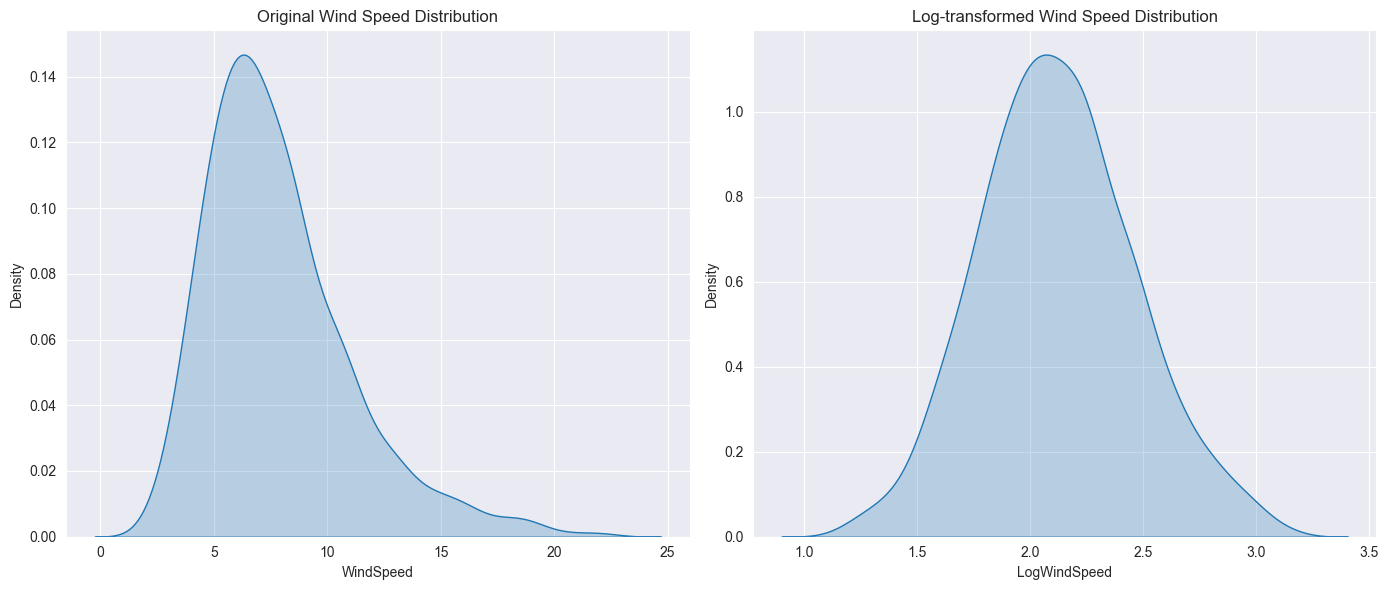

In [41]:
# 创建一个假设的风速数据集，其中包含100个正值
np.random.seed(0)
wind_speed = np.random.lognormal(mean=2, sigma=0.4, size=1000) # 生成一个对数正态分布的数据集，存在左偏，需要进行对数变换

# 创建一个DataFrame来存储风速及其对数转换的值
wind_df = pd.DataFrame({'WindSpeed': wind_speed,
                        'LogWindSpeed': np.log1p(wind_speed)})

# 绘制原始风速的分布
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(wind_df['WindSpeed'], fill=True)
plt.title('Original Wind Speed Distribution')

# 绘制对数转换后风速的分布
plt.subplot(1, 2, 2)
sns.kdeplot(wind_df['LogWindSpeed'], fill=True)
plt.title('Log-transformed Wind Speed Distribution')

plt.tight_layout()
plt.show()


## 3.2 Counts
用于聚合多个二元特征并创建一个计数特征，这种类型的特征表示某事物的存在（标记为1或True）或缺失（标记为0或False）。

这种方法的优势是能够将多个相关的二元特征简化为一个数值特征，这对于模型训练可能是有益的，因为它减少了特征的数量，同时保留了关键信息。

在此示例中，这些特征用于描述交通事故数据集中是否有某些道路对象（如十字路口、铁路道口等）靠近事故现场。

In [42]:
# 假设的交通事故数据集
data = {
    "Amenity": [False, False, True, False, True, False, False, True, False, False],
    "Bump": [False, False, False, False, False, False, False, False, False, False],
    "Crossing": [False, False, False, False, True, False, True, False, False, False],
    "GiveWay": [False, False, False, False, False, False, False, False, True, False],
    "Junction": [False, False, False, True, False, True, False, False, False, False],
    "NoExit": [False, True, False, False, False, False, False, False, False, True],
    "Railway": [False, False, False, False, False, False, True, False, False, False],
    "Roundabout": [False, False, False, False, False, True, False, False, False, False],
    "Station": [False, False, True, False, False, False, False, False, False, False],
    "Stop": [False, False, False, False, False, False, False, True, False, False],
    "TrafficCalming": [False, False, False, False, False, False, False, False, False, False],
    "TrafficSignal": [False, True, False, False, False, False, False, False, False, False]
}

accidents = pd.DataFrame(data)

# 列出所有道路特征
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
                    "Junction", "NoExit", "Railway", "Roundabout",
                    "Station", "Stop", "TrafficCalming", "TrafficSignal"]

# 计算每条记录中存在的道路特征的总数
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

# 显示数据框的前10行，最后一列为新生成的特征，表示每条记录中存在的这些道路特征的总数
accidents.head(5)


,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,True,False,False,False,False,False,True,2
2,True,False,False,False,False,False,False,False,True,False,False,False,2
3,False,False,False,False,True,False,False,False,False,False,False,False,1
4,True,False,True,False,False,False,False,False,False,False,False,False,2


## 3.3 Building-Up and Breaking-Down Features
- **Building-Up**：将多个特征组合成一个新的特征
- **Breaking-Down**：将一个特征分解成多个特征

一般可以用str accessor来进行字符串的处理，比如使用str.split()来将一个字符串特征分解成多个特征。

或者使用`str1`+`str2`来将两个字符串特征组合成一个新的特征。



## 3.4 Group Transforms
`groupby()`函数可以用于对数据进行分组，然后对每个组应用一个函数，最后将结果合并成一个数据框。

在 Pandas 中，`groupby()` 后可以跟随 `apply()`, `agg()` 或 `transform()`，这些函数都用于对分组数据进行某种操作，但它们各有特点和适用场景。

### 1. `apply()`
- `apply()` 函数对每个分组应用一个函数，可以是预定义的、匿名的或自定义的函数。这个函数可以返回一个标量、系列或数据框。
- `apply()` 是这三个函数中最灵活的，可以用于复杂的操作，如：返回多列的数据框或基于整个分组数据的计算。
- 但是，`apply()` 通常比 `agg()` 和 `transform()` 慢，特别是在处理大数据集时。

### 2. `agg()`
- `agg()`（或 `aggregate()`）函数用于应用一个或多个聚合操作到每个分组。聚合操作返回的是每个组的单个结果（如：`sum`, `mean`, `min`, `max` 等）。
- 使用 `agg()` 可以一次性对同一列应用多个聚合函数，或对不同列应用不同的聚合函数。
- `agg()` 适用于当你需要对数据分组进行简单的缩减（reduction）或汇总操作时。

### 3. `transform()`
- `transform()` 函数将一个函数应用于每个分组，然后将结果放回原来的索引位置上。返回的对象与组大小相同。
- 这对于标准化数据或填充 NaN 值非常有用，因为它允许保留数据的原始形状。
- `transform()` 适用于需要保留输入数据形状的转换操作。

每个函数都有其特定的用途，选择哪个函数取决于你的具体需求。

在 Pandas 中，`apply`、`agg` 和 `transform` 的行为确实有所不同，尤其是在处理多列数据时。这些差异主要是因为它们处理聚合操作和返回结果的方式不同。

1. **`apply()`**：
   - `apply()` 函数在分组上应用传递给它的函数，并且可以返回一个标量、系列或数据框。它在分组上应用函数，就像它在一个小型的数据框上操作一样。
   - 当使用 `lambda x: x.sum()` 时，`apply()` 对每个分组的数据框执行了 `sum()` 操作。在这个过程中，数值列被相加，而字符串列则被连接在一起，因为 `sum()` 对于字符串的默认行为是字符串连接。

2. **`agg()` 和 `transform()`**：
   - `agg()` 和 `transform()` 函数更专注于执行特定的聚合操作。当你指定 `sum` 作为聚合函数时，这两个函数只对数值列进行求和操作，并忽略非数值列。
   - 由于 `agg()` 和 `transform()` 在执行 `sum` 时不对字符串列进行操作，因此它们不会像 `apply()` 那样将字符串连接起来。

这就解释了为什么使用 `apply` 时会得到与 `agg` 和 `transform` 不同的结果。`apply` 对每个列都执行了 `sum()` 操作（包括字符串的连接），而 `agg` 和 `transform` 只对数值列执行求和。

简而言之，`apply` 在处理多列数据时的行为更为通用和灵活，但这也意味着它的行为可能会与 `agg` 和 `transform` 不同，特别是在涉及到混合类型数据时（比如同时包含字符串和数字的情况）。

In [43]:
df = pd.DataFrame({
    'Category': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Data': [1, 2, 3, 4, 5, 6]
})
print(df)

# 使用 apply()
result_apply = df.groupby('Category').apply('sum')

result2_apply= df.groupby('Category').apply(lambda x: x.sum())
# x是包含 'Category' 和 'Data' 两个列的小数据框，对每个类别 'A', 'B', 'C' 分别进行操作。当你对这样的数据框调用 sum() 方法时，它会对所有列进行求和。
# 对于数值列‘Data’，直接相加，得到3,7,11；对于字符串列‘Category’，进行拼接，得到AA,BB,CC

# 使用 agg()
result_agg = df.groupby('Category').agg('sum') # agg('sum')和agg(lambda x: x.sum())是等价的

# 使用 transform()
result_transform = df.groupby('Category').transform('sum') # transform('sum')和transform(lambda x: x.sum())是等价的

print('\napply:\n',result_apply)
print('\napply2:\n',result2_apply)
print('\nagg:\n',result_agg)
print('\ntransform:\n',result_transform)


  Category  Data
0        A     1
1        A     2
2        B     3
3        B     4
4        C     5
5        C     6

apply:
           Data
Category      
A            3
B            7
C           11

apply2:
          Category  Data
Category               
A              AA     3
B              BB     7
C              CC    11

agg:
           Data
Category      
A            3
B            7
C           11

transform:
    Data
0     3
1     3
2     7
3     7
4    11
5    11


# 4. Clustering
Clustering是一种无监督学习方法，它将数据分成不同的组，每个组称为一个cluster。每个cluster中的数据点都有一些共同的特征，而不同的cluster之间的数据点具有不同的特征。
在特征工程中，我们可以使用聚类来创建新的特征，这些特征可以帮助模型更好地理解数据。

## 4.1 K-Means Clustering
使用K-Means聚类算法，将数据分成K个cluster，每个cluster的中心点称为centroid。K-Means算法的目标是最小化每个数据点到其所属cluster的centroid的距离之和，这个距离一般为Euclidean距离。

- `.fit_predict()`：用于训练模型并预测每个数据点所属的cluster
- `.fit_transform()`：用于训练模型并将数据转换为每个数据点到其所属cluster的centroid的距离distance


   Feature_1  Feature_2  Categories
0  -7.338988  -7.729954           2
1  -7.740041  -7.264665           2
2  -1.686653   7.793442           0
3   4.422198   3.071947           1
4  -8.917752  -7.888196           2
   Feature_1  Feature_2  Cluster_Labels
0  -7.338988  -7.729954               1
1  -7.740041  -7.264665               1
2  -1.686653   7.793442               2
3   4.422198   3.071947               0
4  -8.917752  -7.888196               1 

distance:
 [[15.522625    0.87384313 17.42111457]
 [15.55503779  0.90100321 17.08911972]
 [ 8.65069655 15.66471908  1.5680663 ]
 [ 1.10996953 15.13105904  9.24334253]
 [16.87347954  2.22581816 18.06045041]]


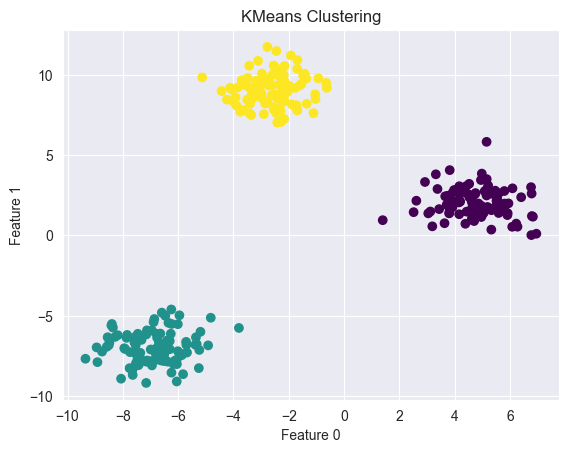

In [92]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 生成一些样本数据,make_blobs用于生成聚类数据,centers表示聚类中心的个数,n_features表示特征的个数即列数
x, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)
df=pd.DataFrame(x,columns=['Feature_1','Feature_2'])
df['Categories']=y
print(df.head(5))

# 初始化KMeans
kmeans = KMeans(n_clusters=3, random_state=42)

# 使用fit_predict方法,得到每个数据点的聚类标签
labels = kmeans.fit_predict(df[['Feature_1', 'Feature_2']])
# 将聚类标签加入到数据框中
df['Cluster_Labels'] = labels
print(df[['Feature_1','Feature_2','Cluster_Labels']].head(5),'\n')
# kmeans得到的聚类标签是0,1,2,不一定与原始数据的类别标签相同,但是同一个类别的数据点的聚类标签是相同的

# 使用fit_transform方法,得到每个数据点到其所属cluster的centroid的距离
distance = kmeans.fit_transform(df[['Feature_1', 'Feature_2']])
print('distance:\n',distance[:5])

# 绘制聚类结果
plt.scatter(df[['Feature_1']], df[['Feature_2']], c=labels, cmap='viridis')
plt.title("KMeans Clustering")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

## 4.2 DBSCAN Clustering
不同于K-Means，DBSCAN是一种基于密度的聚类算法，它将数据分成不同的cluster，每个cluster的数据点具有相似的密度。

DBSCAN聚类算法在处理数据时不需要指定cluster的个数，它会自动识别出数据中的cluster个数。

DBSCAN 算法的工作原理如下：

1. **密度的定义**：对于每个点，算法计算其邻域内的点数。邻域由一个半径 `eps` 定义，这是一个距离阈值，它确定在多大的范围内搜索其他点。

2. **核心点**：如果一个点的 `eps`-邻域内有超过某个指定数量（`min_samples`）的点，那么这个点就被认为是一个核心点。这意味着它位于一个密集区域的中心。

3. **直接密度可达**：如果一个点在核心点的邻域内，那么它是直接密度可达的。这些点被分配到核心点所在的聚类中。

4. **密度可达**：如果有一系列的点，每个点都是直接密度可达的（从第一个核心点开始），那么聚类会扩展到这些点。

5. **噪声**：不属于任何核心点邻域的点被认为是噪声。

在这张图片上，通过 DBSCAN 聚类算法，那些紧密聚集在一起的点（即在 `eps` 阈值内互相邻近）被识别为聚类的一部分，而那些相对孤立的点被认为是噪声。这就是为什么我们看到不同颜色的点聚集在一起形成不同的聚类，每种颜色代表一个不同的密度聚类。

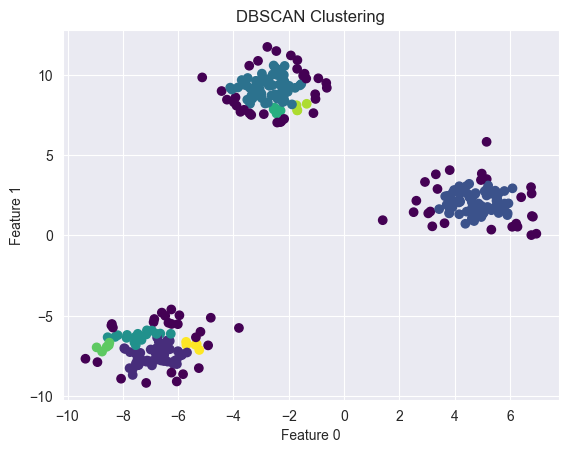

In [96]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# 生成一些模拟数据,make_moons用于生成
X, y = make_blobs(n_samples=300, centers=3,n_features=2, random_state=42)

# 初始化 DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=5)

# 拟合模型
labels = dbscan.fit_predict(X)

# 可视化结果
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# 5. Principal Component Analysis (PCA)
主成分分析（PCA）是一种无监督学习方法，它可以将数据从高维空间降维到低维空间，同时保留数据中的大部分信息。

## 5.1 PCA（主成分分析）原理

主成分分析（PCA）是一种统计方法，用于通过线性变换将数据转换到新的坐标系统中，使得数据在新坐标轴（主成分）上的投影方差最大。PCA的关键步骤如下：

1. **标准化数据**：对数据进行标准化处理，使各个特征的均值为0，方差为1。
2. **计算协方差矩阵**：通过数据点的标准化值计算协方差矩阵。协方差矩阵反映了数据各维度之间的相关性。
3. **计算特征值和特征向量**：对协方差矩阵进行特征分解，得到特征值和对应的特征向量。
4. **选择主成分**：根据特征值的大小选择最重要的几个特征向量。这些特征向量定义了新的空间，其中数据的方差最大。
5. **数据降维**：使用选定的主成分将原始数据转换到新的空间中。

### 应用场景

1. **数据降维**：在处理具有大量特征的数据集时，PCA可以减少特征的数量，同时尽可能保留数据的重要信息。
2. **噪声过滤**：去除数据中的噪声，并找出数据的主要趋势。
3. **可视化**：将多维数据降至二维或三维，便于可视化。
4. **特征提取和数据压缩**：在模式识别和机器学习中作为特征提取工具，有助于提高算法效率和减少计算成本。

### Python 代码示例

以下是一个使用Python中的`sklearn`库进行PCA的简单示例：

- `PCA(n_components)`：用于指定主成分的个数，即降维后的维度.
- `fit_transform()`：用于拟合模型并将数据转换到主成分坐标系中.
- `components_`：用于获取主成分（特征向量）.
- `explained_variance_ratio_`：用于获取解释的方差比例，即每个主成分解释的方差占总方差的比例.

可以看到原本数据为3*2矩阵，经过PCA降维后，第二列变为一个0向量，即所有信息都可以由第一列给出。



In [134]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 示例数据
X = np.array([[1, 2], [3, 4], [5, 6]])
print('原数据（三维）：\n',X)

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 应用PCA,指定主成分的个数为2; n_components<=min(n_samples,n_features),n_samples为样本个数，即行数，n_features为特征个数，即列数
pca = PCA(n_components=2)
pca.fit(X_scaled)

# 输出主成分
print("主成分（特征向量）:\n", pca.components_)

# 输出解释的方差比例
# print("解释的方差比例:", pca.explained_variance_ratio_)
# 解释的方差比例: [1.00000000e+00 4.10865055e-33],第一个主成分解释了100%的方差，第二个主成分解释了0%的方差

# 将数据转换到主成分坐标系
X_pca = pca.transform(X_scaled)
# print("转换后的数据:\n", X_pca)

# 将转换后的数据转换为DataFrame，列名为PC1,PC2
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
print(X_pca.head())

原数据（三维）：
 [[1 2]
 [3 4]
 [5 6]]
主成分（特征向量）:
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
        PC1  PC2
0 -1.732051  0.0
1  0.000000  0.0
2  1.732051  0.0


#### 载荷矩阵 Loadings
载荷矩阵显示了原始特征与主成分之间的关系。pca.components_提供了一个载荷矩阵，其中的每一行对应一个主成分，每一列对应一个原始特征。这个矩阵被转置（.T），使得行变成原始特征，列变成主成分。最后，创建一个新的DataFrame loadings 来存储这个矩阵，并打印出来。

载荷值（loadings）显示了每个原始特征对每个主成分的贡献程度，可以帮助理解每个主成分背后的意义。
- 正载荷（Positive Loadings）: 当载荷为正数时，这意味着原始特征与对应的主成分正相关。即当该特征的值增加时，主成分的值也倾向于增加。
- 负载荷（Negative Loadings）: 当载荷为负数时，表示原始特征与对应的主成分负相关。即当该特征的值增加时，主成分的值倾向于减少。

In [136]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=['ori-feature1','ori-feature2']  # and the rows are the original features
)
print('载荷矩阵：\n',loadings)

载荷矩阵：
                    PC1       PC2
ori-feature1  0.707107  0.707107
ori-feature2  0.707107 -0.707107


#### 可视化主成分
图一为解释变量的方差比例，图二为累计方差比例。

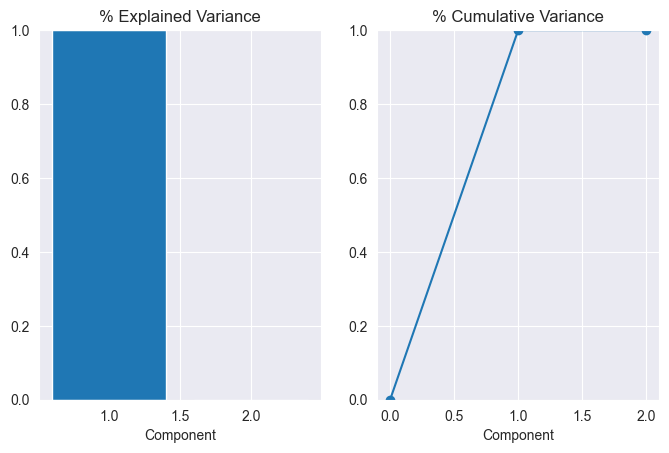

In [125]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_ # 解释的方差比例
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr) # 累计方差比例，np.cumsum()函数用于累加数组中的元素
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

## 5.2 PCA for Feature Engineering
### Using Cases

第一种方式是将其作为**描述性技术**使用。由于成分告诉你关于变异的信息，你可以计算主成分和目标变量的互信息（MI）得分，看看哪种类型的变异最能预测你的目标。这可能会给你一些创造特征的想法——例如，如果“大小”很重要，可以考虑“高度”和“直径”的乘积；如果“形状”重要，可以考虑“高度”和“直径”的比率。你甚至可以尝试对一个或多个高得分的成分进行聚类。

第二种方式是将成分本身**作为特征**使用。因为成分直接暴露了数据的变异结构，它们往往比原始特征更有信息性。以下是一些使用案例：
- 降维：当你的特征高度冗余（特别是多重共线性时），PCA会将冗余分配到一个或多个接近零方差的成分中，然后你可以删除这些成分，因为它们几乎不包含信息。
- 异常检测：不寻常的变异，如果不从原始特征中明显显示出来，通常会出现在低方差成分中。在异常或离群值检测任务中，这些成分可能非常有信息性。
- 降噪：传感器读数的集合通常会共享一些常见的背景噪声。PCA有时可以将（有信息的）信号收集到更少的特征中，同时保留噪声，从而提高信噪比。
- 去相关：一些机器学习算法难以处理高度相关的特征。PCA将相关特征转换为不相关的成分，这可能更容易被你的算法处理。

### Best Practices
- **标准化数据**：在使用PCA之前，需要对数据进行标准化处理。
- **使用numeric features**：PCA只能用于数值特征，因此需要将分类特征转换为数值特征。
- **处理outliers**：PCA对outliers非常敏感，因此需要在使用PCA之前处理outliers。

# 6. Target Encoding
目标编码是一种处理分类特征的编码技术，常用于机器学习中。它的核心思想是用某种从目标变量（如分类的标签或回归的值）中衍生出的数值来替换原始分类特征的每个类别。这种编码方法特别适用于那些类别较多的分类特征。

在目标编码中，常见的操作是计算每个类别相对于目标变量的平均值。例如，在处理房价预测问题时，我们可以将“城市”这个分类特征进行目标编码，方法是计算每个城市中所有房屋的平均价格，然后用这个平均价格来替换原来的城市名称。这样，原本是名义上的分类变量就被转换成了数值型变量，其中包含了关于目标变量的有用信息。


目标编码的优点包括：
1. 简化模型：它将高维的分类数据转换为低维的数值数据，减少了模型的复杂性。
2. 提高效率：数值型特征通常比原始的分类特征更容易被模型利用。
3. 捕捉信息：目标编码可以捕捉类别特征和目标变量之间的关系。

然而，目标编码也有潜在的风险，比如过拟合。特别是在类别内数据点较少的情况下，用类别平均值来代替可能导致过于依赖这些少量的数据点，从而影响模型的泛化能力。为了缓解这个问题，可以采用正则化或平滑的方法，例如加入噪声，或者与全局平均值（所有数据的目标平均）结合使用。

## 6.1 目标编码的基本步骤：

1. **确定目标变量和分类特征**：首先，你需要明确哪个是目标变量（比如回归问题中的房价，分类问题中的标签等），以及哪些分类特征需要进行目标编码。

2. **计算每个类别的目标均值**：对于每个类别，在训练数据集中计算该类别相对于目标变量的平均值。例如，如果你正在处理一个预测房价的问题，你可能会计算每个地区的平均房价。

3. **替换特征值**：将分类特征中的每个类别替换为计算出的对应目标均值。这样，原来的分类特征就被转换为数值特征。

4. **处理新数据**：在将模型应用于新数据（如测试集）时，使用在训练集上计算得到的目标均值来替换类别。如果遇到训练集中未出现的新类别，或该类别只出现过很少的次数，可以使用全局平均值（所有训练数据的目标均值）作为替换。这种方法称为`Smoothing`。

5. **防止过拟合**：为了避免过拟合，可以采取一些策略，比如使用交叉验证来计算目标均值，或者对均值进行平滑处理，例如与全局均值的加权平均。

6. **模型训练和验证**：在目标编码处理之后，你可以使用这些转换后的特征来训练和验证你的机器学习模型。

## 6.2 Using Cases：

目标编码（Target Encoding）是一种特征工程技术，特别适用于以下使用情景：

1. **高基数分类特征**：当分类特征具有大量类别（即高基数）时，独热编码会产生大量的特征，导致维度灾难。目标编码可以有效地将这些类别转换为有意义的数值，减少特征数量并保留重要信息。

2. **类别与目标变量有强关联**：当分类特征的类别与目标变量有明显的关联性时，目标编码可以帮助模型更好地捕捉这种关系。例如，在预测房价的任务中，某些地理位置（区域、邻里）可能与房价有很强的相关性。

3. **树模型优化**：虽然决策树和基于树的模型（如随机森林、梯度提升机）可以很好地处理分类特征，但目标编码可以进一步提升这类模型的性能，特别是在处理具有许多类别的特征时。

4. **缺少数据或新类别处理**：对于数据集中存在未知类别或缺少数据的情况，目标编码提供了一种处理新类别的策略，即使用全局均值或其他统计量作为替代值。

5. **正则化/平滑**：在类别样本数量很少的情况下，直接计算的目标均值可能会导致过拟合。目标编码允许通过平滑这些均值（如与全局均值混合）来引入正则化，从而提高模型的泛化能力。

6. **处理非线性关系**：目标编码可以将非线性关系映射为线性特征，这在使用线性模型（如线性回归、逻辑回归）时尤其有用。

在使用目标编码时，需要注意避免信息泄露和过拟合。合理的做法是在交叉验证的框架下进行编码，或者在训练集上计算编码值后应用到测试集，以确保模型的有效性和可靠性。

In [4]:
# 使用boston房价数据集
from sklearn.datasets import load_boston

# 加载波士顿房价数据集
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = boston.target # 目标变量为房价中位数 'MEDV'

# 一般对于分类特征才需要进行目标编码，这里为了演示，对连续型变量 'RM' 进行目标编码
# 使用 'RM' 特征进行示例 RM为每个住宅的平均房间数，属于连续型变量 将其离散化成分类特征
boston_df['RM_cat'] = np.round(boston_df['RM']) # np.round()函数用于四舍五入，将连续型变量转换为离散型变量
print('Original data:\n',boston_df[['RM', 'RM_cat', 'MEDV']].head(5))

# 计算每个 'RM_cat' 类别的 'MEDV' 平均值
# transform()函数用于将每个类别的 'MEDV' 替换为对应的目标均值,输出于每一行
boston_df['RM_cat_mean'] = boston_df.groupby('RM_cat')['MEDV'].transform('mean') 

# 显示处理后的前几行数据
print('After target encoding:\n',boston_df[['RM', 'RM_cat','RM_cat_mean', 'MEDV']].head(5))


Original data:
       RM  RM_cat  MEDV
0  6.575     7.0  24.0
1  6.421     6.0  21.6
2  7.185     7.0  34.7
3  6.998     7.0  33.4
4  7.147     7.0  36.2
After target encoding:
       RM  RM_cat  RM_cat_mean  MEDV
0  6.575     7.0    28.047200  24.0
1  6.421     6.0    19.366026  21.6
2  7.185     7.0    28.047200  34.7
3  6.998     7.0    28.047200  33.4
4  7.147     7.0    28.047200  36.2


## 6.3 Smoothing and Regularization
在目标编码中，如果某个类别的样本数量很少，那么用该类别的目标均值来替换可能会导致过拟合。为了缓解这个问题，可以采用正则化或平滑的方法，例如加入噪声，或者与全局平均值（所有数据的目标平均）结合使用。

使用`MEstimateEncoder`类可以实现平滑的目标编码，它的主要参数有：
- `cols`：需要进行目标编码的特征列表. 若不指定，则默认对所有分类特征进行目标编码。
- `m`：平滑参数，用于控制平滑的程度。m越大，平滑程度越高，对于样本数量较少的类别，其目标均值会更接近全局均值。
- `smoothing_strategy`：平滑策略，可选值为`mean`和`median`，默认为`mean`。如果设置为`mean`，则用全局均值替换样本数量较少的类别的目标均值；如果设置为`median`，则用全局中位数替换样本数量较少的类别的目标均值。
- `handle_unknown`：未知类别的处理策略，可选值为`error`和`value`，默认为`value`。如果设置为`error`，则当遇到未知类别时，会抛出异常；如果设置为`value`，则会用全局均值替换未知类别的目标均值。
- `handle_missing`：缺失值的处理策略，可选值为`error`和`value`，默认为`value`。如果设置为`error`，则当遇到缺失值时，会抛出异常；如果设置为`value`，则会用全局均值替换缺失值的目标均值。
- `randomized`：是否使用随机化的方法来计算目标均值，可选值为`True`和`False`，默认为`False`。如果设置为`True`，则会在计算目标均值时加入随机噪声，以减少过拟合的风险。

---

具体来说，`m` 的值确定了在编码每个类别时，类别自身的目标均值与全局目标均值（即所有数据的目标均值）之间的权衡：

- 当 `m` 很小（接近于0）时，编码更多地依赖于类别自身的目标均值。这可能在类别内有足够多的样本时效果更好，但如果某些类别的样本量很小，则可能导致过拟合。

- 当 `m` 增大时，编码更多地考虑全局目标均值。这提供了一种正则化效果，减少了过拟合的风险，尤其是在某些类别样本量较小的情况下。

- 一个较大的 `m` 值（例如10或更高）意味着即使类别内样本数量很少，编码值也会更倾向于全局均值。

`m` 参数的合适值通常取决于具体数据集的特征，如类别的分布和样本大小。在实际应用中，可能需要通过交叉验证来确定最优的 `m` 值。通过调整 `m`，`MEstimateEncoder` 能够在降低过拟合风险和保留类别特异性信息之间找到平衡。


In [37]:
from sklearn.datasets import load_boston
from category_encoders import MEstimateEncoder

# 加载波士顿房价数据集
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = boston.target

# 随机分割数据集为编码集（20%）和训练集（80%）
X_encode = boston_df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop('MEDV')

# X_train为原数据集去除编码集后的数据
X_train = boston_df.drop(X_encode.index)
y_train = X_train.pop('MEDV')

# 创建MEstimateEncoder实例，假设m=1.0
encoder = MEstimateEncoder(cols=['CHAS'], m=1.0)

# 拟合编码器到编码分割数据
encoder.fit(X_encode, y_encode)

# 应用编码器到训练分割数据
X_train_encoded = encoder.transform(X_train)

# 将编码后的数据添加回原始DataFrame
boston_df.loc[X_train.index, 'CHAS_ME'] = X_train_encoded['CHAS']

# 打印结果
print(boston_df[['CHAS', 'CHAS_ME', 'MEDV']].head())



   CHAS    CHAS_ME  MEDV
0   0.0  21.839406  24.0
1   0.0        NaN  21.6
2   0.0  21.839406  34.7
3   0.0  21.839406  33.4
4   0.0  21.839406  36.2


C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Ca